## Dataset preparation


In [1]:
import polars as pl

In [2]:
df = pl.scan_csv("abo-images-small/images/metadata/images.csv.gz")

In [3]:
df.columns

C:\Users\barte\AppData\Local\Temp\ipykernel_3936\3289350417.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  df.columns


['image_id', 'height', 'width', 'path']

In [4]:
df_filtered = df.filter((pl.col("height") > 1000) & (pl.col("width") > 1000)).collect()

## Model Selection and Understanding


In [5]:
from sentence_transformers import SentenceTransformer

In [6]:
model = SentenceTransformer("clip-ViT-B-32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
model.encode(["test"]).shape

(1, 512)

What is the vector size produced by clip-ViT-B-32?

- 512 dimensions

What do `ViT`, `B` and `32` mean in the model name?

- `ViT` -> `Vision transformer`
- `B` -> `Base` - refereing to the model size
- `32` -> `32 pixels` - the block size used by the transformer


## Database setup


In [8]:
from sqlalchemy.engine import URL
import sqlalchemy

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db",
)

In [9]:
from sqlalchemy import create_engine

engine = create_engine(db_url)

In [10]:
from pgvector.sqlalchemy import Vector
from sqlalchemy import Integer, String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
from typing import List


class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    __tablename__ = "images"
    __table_args__ = {"extend_existing": True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))


Base.metadata.create_all(engine)

## Image vectorization


In [33]:
import joblib
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from itertools import batched
from sqlalchemy.orm import Session

MAX_IMAGES = 1000
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)


def insert_images(engine, imgs):
    with Session(engine) as session:
        session.add_all(imgs)
        session.commit()


def vectorize_images(engine, model, image_paths):
    print(MAX_IMAGES, BATCH_SIZE)

    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in list(batched(image_paths[:MAX_IMAGES], BATCH_SIZE)):
            images = [
                Image.open(f"abo-images-small/images/small/{path}")
                for path in images_paths_batch
            ]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            imgs = [
                Img(image_path=path, embedding=embedding)
                for path, embedding in zip(images_paths_batch, embeddings)
            ]

            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            pbar.update(len(imgs))


vectorize_images(engine, model, df_filtered["path"].to_list())

1000 4


  0%|          | 0/1000 [00:00<?, ?it/s]

## Search and results display


In [28]:
import matplotlib.pyplot as plt


class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        self.display_images(found_images, k)

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(image_description)

        # remember about session and commit
        with Session(self.engine) as session:
            query = (
                session.query(Img.image_path)
                .order_by(Img.embedding.cosine_distance(image_embedding))
                .limit(k)
            )
            result = query.all()

        return [path for (path,) in result]

    def display_images(self, images, k):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(images):
            img = Image.open(f"abo-images-small/images/small/{img_path}")
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")

        plt.show()

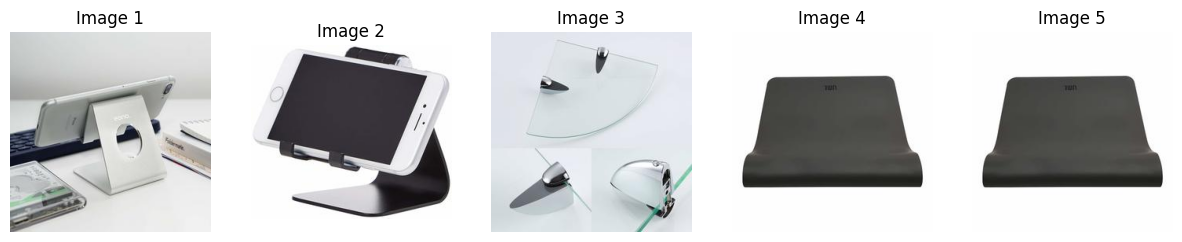

In [29]:
ImageSearch(engine, model)("Laptop on a desk", 5)

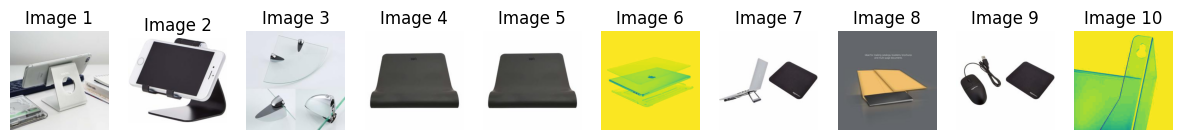

In [30]:
ImageSearch(engine, model)("Laptop on a desk", 10)

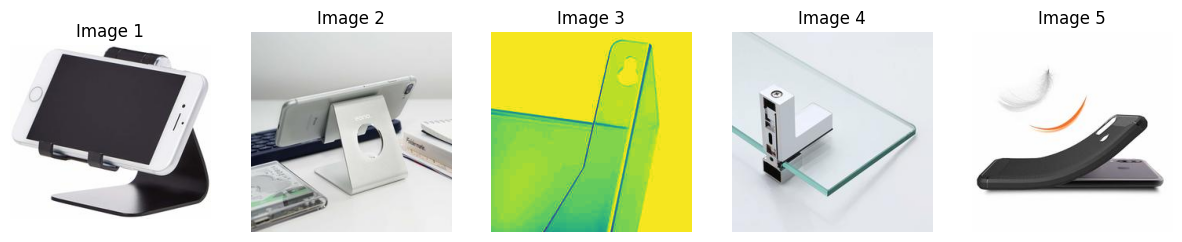

In [31]:
ImageSearch(engine, model)("Mobile phone on the desk", 5)

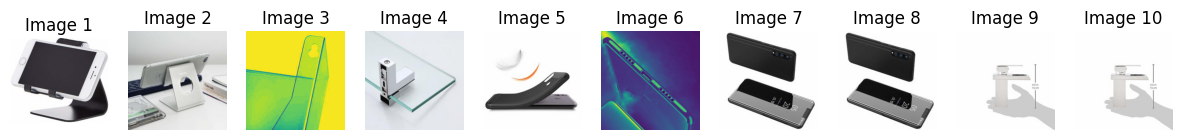

In [32]:
ImageSearch(engine, model)("Mobile phone on the desk", 10)

In [34]:
MAX_IMAGES = 500
vectorize_images(engine, model, df_filtered["path"].to_list())

500 4


  0%|          | 0/500 [00:00<?, ?it/s]

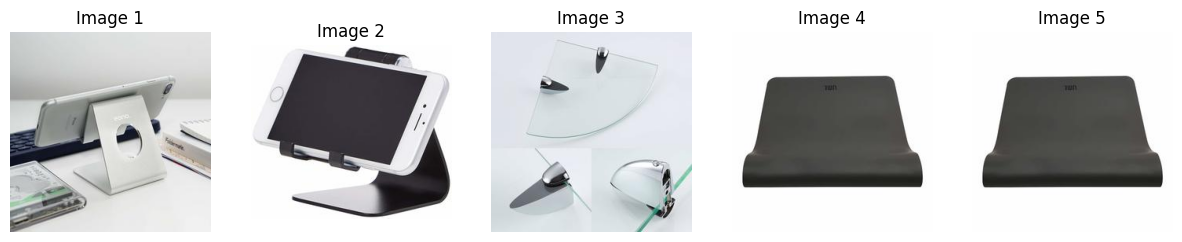

In [35]:
ImageSearch(engine, model)("Laptop on a desk", 5)

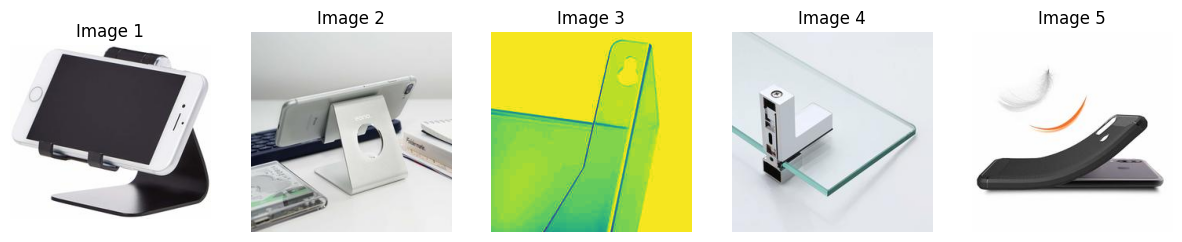

In [36]:
ImageSearch(engine, model)("Mobile phone on the desk", 5)

In [37]:
MAX_IMAGES = 5000
vectorize_images(engine, model, df_filtered["path"].to_list())

5000 4


  0%|          | 0/5000 [00:00<?, ?it/s]

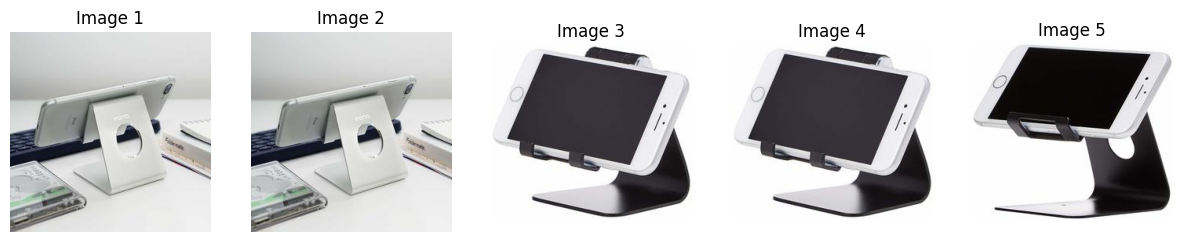

In [38]:
ImageSearch(engine, model)("Laptop on a desk", 5)

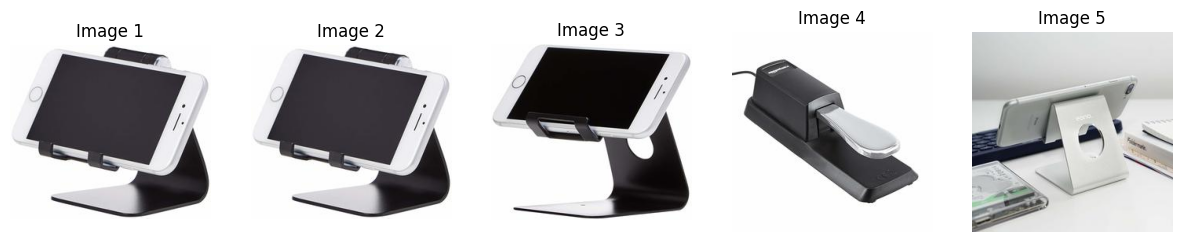

In [39]:
ImageSearch(engine, model)("Mobile phone on the desk", 5)